# Loading and visualizing data from a NetCDF file 

In this notebook, we will use [Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#opening-netcdf-data) to open up the NetCDF file

Start by import the necessary packages. 

- [cartopy](https://scitools.org.uk/cartopy/docs/latest/): for maps
- [cmocean](https://matplotlib.org/cmocean/): pretty(!) colormaps for common variables in oceanography
- [numpy](https://numpy.org/doc/): n-dimensional arrays in python
- [xarray](https://docs.xarray.dev/): for loading and managing multi-dimensional data

In [36]:
import cartopy.crs as ccrs
import cmocean
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Example 1: NASA-Aqua Modis Chlorophyll data

Define the path to the data. Note that I downloaded the data and put it in a `./data/` directory

In [2]:
filepath = "./data/AQUA_MODIS.20220821_20220828.L3m.8D.CHL.chlor_a.4km.NRT.nc"

We will use Xarray to load the dataset into an object called `ds_chlor`. Note that Xarray has a nice way to display what is in the NetCDF file

In [3]:
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20220821_20220828.L3m.8D.CHL...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        13549701
    data_minimum:                     0.004916328
    data_maximum:                     86.36774

Now that we have the object created, we can access individual fields.

In [4]:
chlor = ds.chlor_a
chlor.shape

(4320, 8640)

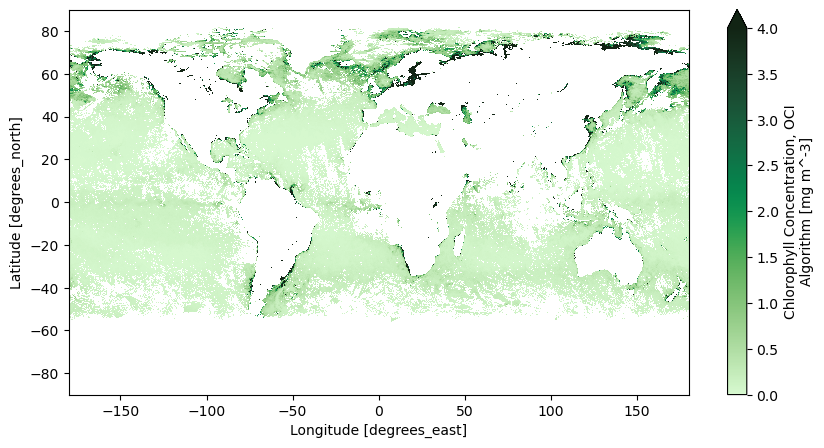

In [6]:
chlor.plot(size=5, aspect=2, vmin=0, vmax=4, cmap=cmocean.cm.algae)

Lets focus on South America

In [52]:
lat_range = np.r_[-70, 20]
lon_range = np.r_[-100, -20]

lat_inds = (
    (chlor.lat >= lat_range.min()) & 
    (chlor.lat <= lat_range.max())
)
lon_inds = (
    (chlor.lon >= lon_range.min()) & 
    (chlor.lon <= lon_range.max())
)
chlor_focus = chlor[lat_inds, lon_inds]

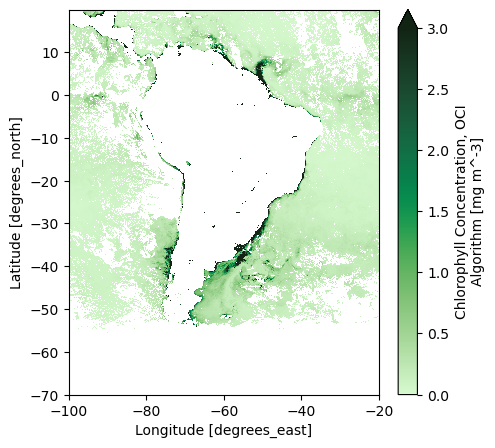

In [75]:
chlor_focus.plot(
    size=5, aspect=1, vmin=0, vmax=3, cmap=cmocean.cm.algae
)

Say we want to project this onto the globe... We will use cartopy for this

In [84]:
lat_range = np.r_[-90, 90]
lon_range = np.r_[-180, 0] 

lat_inds = (
    (chlor.lat >= lat_range.min()) & 
    (chlor.lat <= lat_range.max())
)
lon_inds = (
    (chlor.lon >= lon_range.min()) & 
    (chlor.lon <= lon_range.max())
)
chlor_west_coast = chlor[lat_inds, lon_inds]

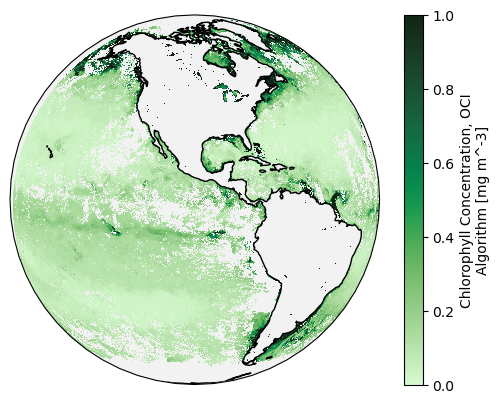

In [86]:
p = chlor_west_coast.plot(
    subplot_kws=dict(
        projection=ccrs.Orthographic(-100, 10), facecolor=0.95*np.r_[1, 1, 1],
    ),
    transform=ccrs.PlateCarree()
)
p.set_clim(np.r_[0, 1])
p.set_cmap(cmocean.cm.algae)

p.axes.set_global()
p.axes.coastlines()

## Example 2: BioArgo data from near Station P

In [89]:
filepath = "./data/BioArgo_5905988_Sprof.nc"
dsargo = xr.load_dataset(filepath)
dsargo

<xarray.Dataset>
Dimensions:                          (N_PROF: 195, N_PARAM: 9, N_CALIB: 1,
                                      N_LEVELS: 407)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/93)
    DATA_TYPE                        object b'Argo synthetic profile          '
    FORMAT_VERSION                   object b'1.0 '
    HANDBOOK_VERSION                 object b'1.2 '
    REFERENCE_DATE_TIME              object b'19500101000000'
    DATE_CREATION                    object b'20220902071317'
    DATE_UPDATE                      object b'20220902071317'
    ...                               ...
    NITRATE                          (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_QC                       (N_PROF, N_LEVELS) object nan nan ... nan
    NITRATE_dPRES                    (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_ADJUSTED                 (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_ADJUSTED_QC              (N_PROF, N_LEVELS) object nan nan ... nan
    NITRATE_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 nan nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2022-09-02T07:13:17Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.14 (version 09.06.2022 for ARGO_simplified_profile)

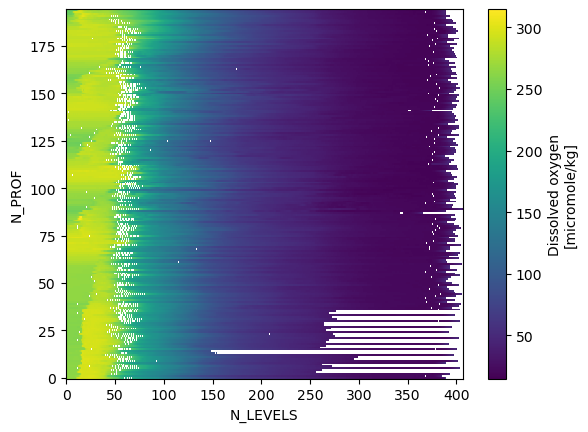

In [98]:
dsargo.DOXY.plot()

It looks like we want `N_PROF` on the x-axis and `N_LEVELS` on the y-axis, so we can specify that in our plot. Since N_LEVELS increases with depth, we will also reverse our axes

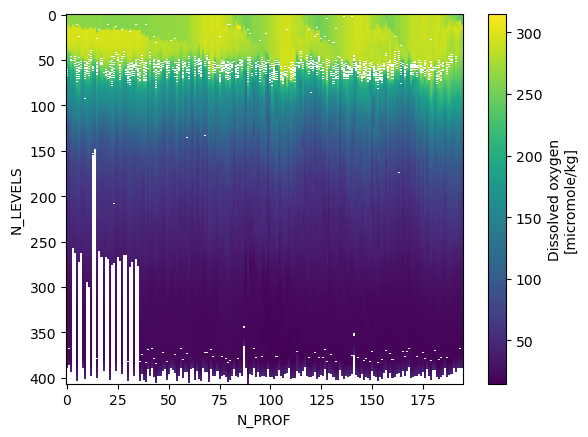

In [105]:
p = dsargo.DOXY.plot(x="N_PROF", y="N_LEVELS")
p.axes.invert_yaxis()

## Example 3: Glider Data

In [107]:
filepath_data = "./data/glider_dfo-k999-20220803.nc"
filepath_grid = "./data/glider_dfo-k999-20220803_grid.nc"

dsglider = xr.load_dataset(filepath_data)
dsglider

<xarray.Dataset>
Dimensions:                (time: 13045)
Coordinates:
  * time                   (time) datetime64[ns] 2022-08-03T15:06:47 ... 2022...
    latitude               (time) float64 48.98 48.98 48.98 ... 48.68 48.68
    longitude              (time) float64 -126.1 -126.1 -126.1 ... -127.0 -127.0
    depth                  (time) float64 nan nan nan nan ... 16.92 nan nan
Data variables: (12/19)
    heading                (time) float64 nan nan nan nan ... 1.792 1.81 nan nan
    pitch                  (time) float64 nan nan nan nan ... 0.486 nan nan
    roll                   (time) float64 nan nan nan ... -0.06646 -0.07379 nan
    waypoint_latitude      (time) float64 nan 0.0 0.0 0.0 ... nan nan nan nan
    waypoint_longitude     (time) float64 nan 0.0 0.0 0.0 ... nan nan nan nan
    conductivity           (time) float64 nan -0.0001 nan ... 3.656 3.861 nan
    ...                     ...
    salinity               (time) float64 nan nan nan 31.0 ... 32.08 31.87 nan
    potential_density      (time) float64 nan nan nan nan ... 1.024e+03 nan nan
    density                (time) float64 nan nan nan ... 1.024e+03 nan
    potential_temperature  (time) float64 nan nan nan 11.87 ... 11.51 14.06 nan
    profile_index          (time) float64 0.0 0.0 0.0 0.0 ... 537.0 0.0 nan
    profile_direction      (time) float64 1.0 1.0 1.0 1.0 ... -1.0 -1.0 0.0 nan
Attributes: (12/65)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    cdm_data_type:             Trajectory
    comment:                   Line P deployment
    contributor_name:          James Pegg, Tetjana Ross, Jody Klymak, Hayley ...
    ...                        ...
    summary:                   Line P near continental shelf.
    time_coverage_end:         2022-08-27T05:02:43.000000000
    time_coverage_start:       2022-08-03T15:06:47.000000000
    title:                     dfo-k999-20220803T1506
    transmission_system:       IRIDIUM
    wmo_id:                    8900995

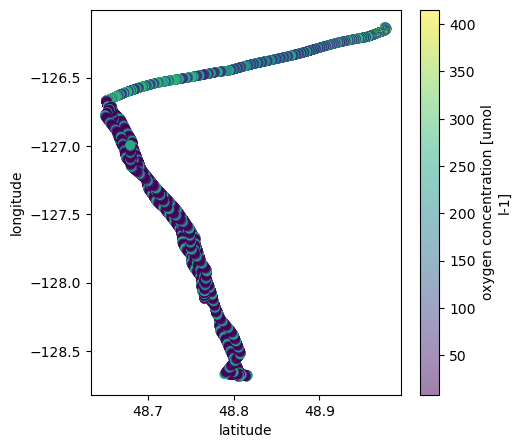

In [120]:
dsglider.plot.scatter(
    x="latitude", y="longitude", hue="oxygen_concentration", 
    size=5, aspect=1, alpha=0.5
)